In [207]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

In [208]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [209]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = 'data/' + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        # acceleration.csvがない場合は作成する
        if 'acceleration.csv' not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)
        
        # 'all.csv'がある場合は削除する
        if 'all.csv' in self.file_names:
            self.file_names.remove('all.csv')
        
        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace('.csv', '')

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(columns={'x': file_type + '_x', 'y': file_type + '_y', 'z': file_type + '_z'})
            
            # 'rotate.csv' に 'w' 列がある場合は削除
            if 'w' in df_tmp.columns and file_name == 'rotate.csv':
                df_tmp = df_tmp.drop(['w'], axis=1)

            if type(df_tmp['time'][0]) == int:
                # 'time'列の変換を実行
                df_tmp['time'] = df_tmp['time'] / 1000
                df_tmp['time'] = pd.to_datetime(df_tmp['time'], unit='s')

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[:, [0] + [i for i in range(1, len(self.df.columns)) if not self.df.columns[i].startswith('time')]]
        self.df['time'] =pd.to_datetime(self.df['time']/1000,unit='s')

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, 'all.csv'), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, 'velocity.csv'))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        df_acc['x'] = df_tmp['x'].cumsum()
        df_acc['y'] = df_tmp['y'].cumsum()
        df_acc['z'] = df_tmp['z'].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, 'acceleration.csv'), index=False)
        df_acc = df_acc.drop(['time'],axis =1 )
        df_acc['acceleration_x'] = df_acc['x']
        df_acc['acceleration_y'] = df_acc['y']
        df_acc['acceleration_z'] = df_acc['z']
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_low_x'
            self.df[out_column] = self.df[column].rolling(n).mean()
            column = column_type + '_y'
            out_column = column_type + '_low_y'
            self.df[out_column] = self.df[column].rolling(n).mean()
            column = column_type + '_z'
            out_column = column_type + '_low_z'
            self.df[out_column] = self.df[column].rolling(n).mean()
        return self
    
    def diff(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.diff(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_diff_x'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_y'
            out_column = column_type + '_diff_y'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_z'
            out_column = column_type + '_diff_z'
            self.df[out_column] = self.df[column].diff()
        return self

    def plot(self, column_type ,option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))
        
        if column_type == 'all':
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    continue
                self.ax(column, option,axis)
                self.i += 1
        else:
            column_type = column_type.replace('.csv', '')
            self.ax(column_type, option,axis)
        plt.show()

    def ax(self, column_type ,option,axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i+1)
        if option == "diff":
            column_type = column_type + '_diff'
        if option == "low":
            column_type = column_type + '_low'  
        match axis:
            case 'x':
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
            case 'y':
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
            case 'z':
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
            case _:
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel('time')
        ax.set_ylabel(column_type)
        ax.grid()

    def split_time(self, start_time, end_time):
        self.df = self.df[(self.df['time'] >= start_time) & (self.df['time'] <= end_time)]
        return self

In [210]:
# oculus_stairsのデータを読み込む
oculus_stairs = Data('oculus_stairs')
oculus_stairs.low_filter('all', filter_num)

In [211]:
# 時間を制限する
start_time = '2023-10-24 11:01:20'
end_time = '2023-10-24 11:02:15'
# end_time = '2023-10-24 11:01:38'
oculus_stairs.split_time(start_time, end_time)

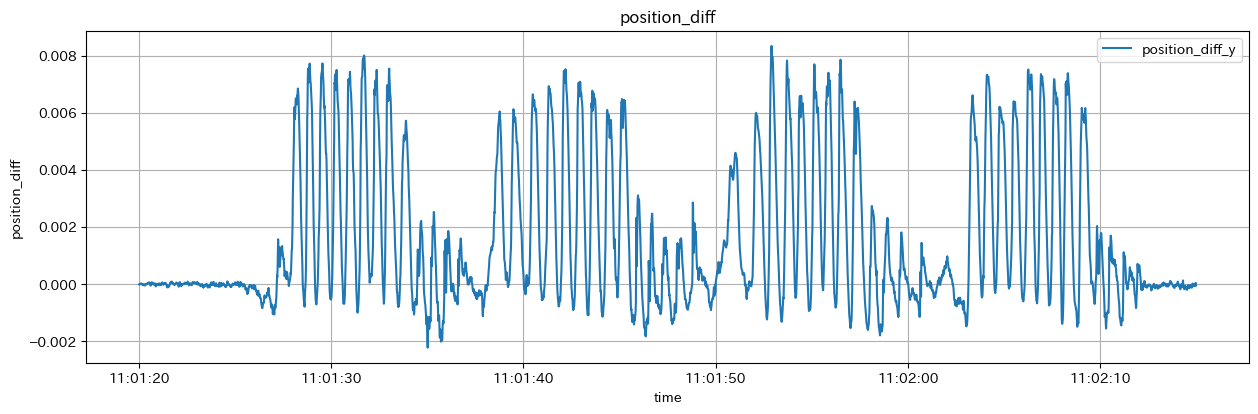

In [212]:
# dfのpositionを微分する
oculus_stairs.diff('position')
oculus_stairs.low_filter('position_diff', filter_num)
oculus_stairs.plot('position', 'diff','y')

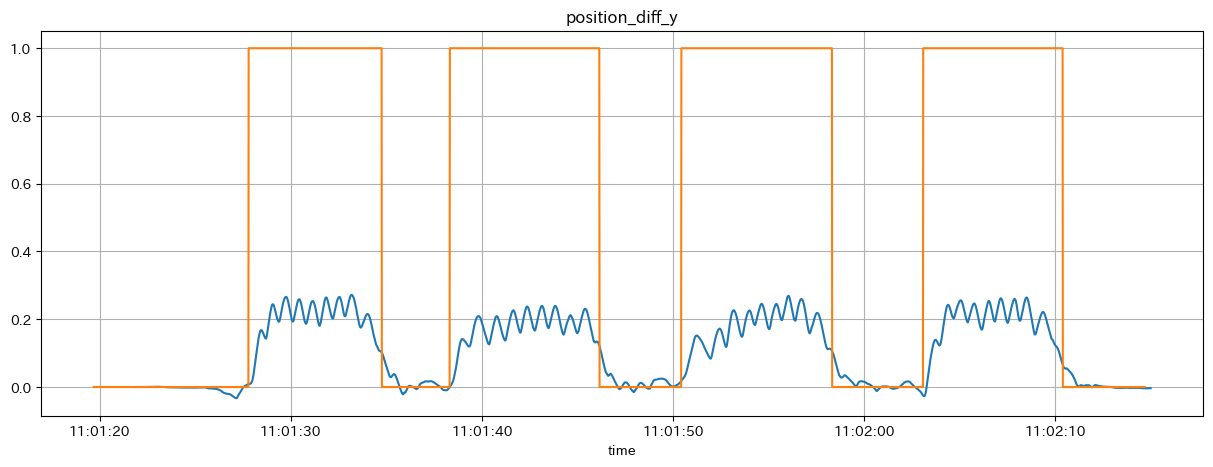

In [267]:
# oculus_stairsのposition_diff_yからpeekを取得して、そのpeekの時間を取得する
peek, _ = signal.find_peaks(oculus_stairs.df['position_diff_y'], distance=20, height=0.004)

df = pd.DataFrame()
df['time'] = oculus_stairs.df['time']

# indexの初期値を取得する
peek_first = oculus_stairs.df.index[0]

# ハイパスフィルターをかける
df['position_y'] = oculus_stairs.df['position_y'] - oculus_stairs.df['position_y'].rolling(filter_num*2,center = False).mean()

# 0.5以上の時は1、0.5以下の時は0にする
df['position_pro_y'] = df['position_y'].apply(lambda x: 1 if x > 0.05 else 0)

# timeをずらす
df['shift_time'] = df['time'] - pd.Timedelta(seconds=0.3)

# 1の時のみのdfを作成する
stair_up_df = pd.DataFrame()
stair_up_df = df[df['position_pro_y'] == 1]

# print(peek)
# indexの初期値を取得する
peek_first = oculus_stairs.df.index[0]
# peekに初期値を足す
peek = peek + peek_first
# peekの時間を取得する
peek_time = oculus_stairs.df['time'][peek]
# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(df['time'], df['position_y'])
plt.plot(df['shift_time'], df['position_pro_y'])
# plt.scatter(peek_time, oculus_stairs.df['position_diff_y'][peek], s=30, color='red', zorder=2)
plt.title('position_diff_y')
plt.xlabel('time')
plt.grid()
plt.show()

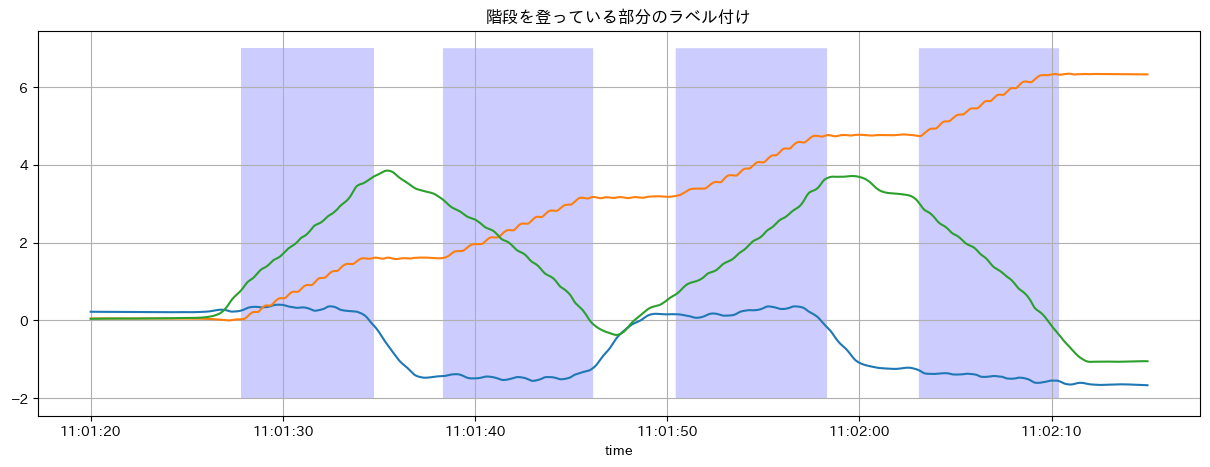

In [269]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['position_x'])
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['position_y'])
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['position_z'])
# 後ろを全体で塗る
ax.fill_between(df['shift_time'], -2, 7, where=(df['position_pro_y'] == 1), facecolor='blue', alpha=0.2)
ax.set_title('階段を登っている部分のラベル付け')
ax.set_xlabel('time')
ax.grid()
plt.show()

In [214]:
print(stair_up_df)
# 保存
stair_up_df.to_csv('stair_up.csv', index=True)


                              time  position_y  position_pro_y
844  2023-10-24 11:01:28.101000192    0.054634               1
845  2023-10-24 11:01:28.116000000    0.060063               1
846  2023-10-24 11:01:28.128000000    0.065690               1
847  2023-10-24 11:01:28.140999936    0.071536               1
848  2023-10-24 11:01:28.155000064    0.077534               1
...                            ...         ...             ...
3905 2023-10-24 11:02:10.628999936    0.053388               1
3906 2023-10-24 11:02:10.642999808    0.052701               1
3907 2023-10-24 11:02:10.656000000    0.052053               1
3908 2023-10-24 11:02:10.670000128    0.051340               1
3909 2023-10-24 11:02:10.684000000    0.050566               1

[2159 rows x 3 columns]


In [215]:
# stair_up_dfでindexが連続していない値を取得する
peek_observe = []

peek_observe.append(stair_up_df.index[0])
out = ''
tmp = 0
for i in range(len(stair_up_df.index)-1):
    if out == 'a':
        peek_observe.append(tmp)
        peek_observe.append(stair_up_df.index[i])
        out =''
        tmp = 0
        continue
    if stair_up_df.index[i] + 1 != stair_up_df.index[i+1]:
        if tmp == 0:
            tmp = stair_up_df.index[i]
        out = 'a'
peek_observe.append(stair_up_df.index[-1])

# peek_observeに対応する時間を取得する
for i in peek_observe:
    if i in oculus_stairs.df.index:
        peek_observe_time.append(oculus_stairs.df['time'][i])

print(peek_observe)
print(peek_observe_time)

[844, 1344, 1601, 2164, 2473, 3040, 3384, 3909]
[Timestamp('2023-10-24 11:01:28.101000192'), Timestamp('2023-10-24 11:01:35.056999936'), Timestamp('2023-10-24 11:01:38.628000'), Timestamp('2023-10-24 11:01:46.446000128'), Timestamp('2023-10-24 11:01:50.740000'), Timestamp('2023-10-24 11:01:58.616000'), Timestamp('2023-10-24 11:02:03.392000'), Timestamp('2023-10-24 11:02:10.684000'), Timestamp('2023-10-24 11:01:28.101000192'), Timestamp('2023-10-24 11:01:35.056999936'), Timestamp('2023-10-24 11:01:38.628000'), Timestamp('2023-10-24 11:01:46.446000128'), Timestamp('2023-10-24 11:01:50.740000'), Timestamp('2023-10-24 11:01:58.616000'), Timestamp('2023-10-24 11:02:03.392000'), Timestamp('2023-10-24 11:02:10.684000'), Timestamp('2023-10-24 11:01:28.101000192'), Timestamp('2023-10-24 11:01:35.056999936'), Timestamp('2023-10-24 11:01:38.628000'), Timestamp('2023-10-24 11:01:46.446000128'), Timestamp('2023-10-24 11:01:50.740000'), Timestamp('2023-10-24 11:01:58.616000'), Timestamp('2023-10-24 

In [216]:
# 階段を登っている間のpeekのposition_yを比較して、平均を取得する
# 登った階段の数
floor = len(peek_observe) / 2

# peek_observe[0]とpeek_observe[1]のpeekのposition_yを比較する
# peekを取得する
print(peek)
floor_peek = []
for i in range(peek_observe[0], peek_observe[1]):
    if oculus_stairs.df['position_y'][i] > oculus_stairs.df['position_y'][i+1]:
        floor_peek.append(i)

print(floor_peek)

# 1段の高さ
floor_step_high = 0
for i in floor_peek:
    print(i)
    stair_step = oculus_stairs.df['position_y'][i+1] - oculus_stairs.df['position_y'][i]
    print(f"after  : {oculus_stairs.df['position_y'][i]} , before : {oculus_stairs.df['position_y'][i+1]} , diff   : {stair_step}")
    floor_step_high += stair_step

floor_step_high = floor_step_high / (peek_observe[1] - peek_observe[0])

print(floor_step_high)

[ 856  900  948 1001 1051 1104 1151 1198 1261 1611 1662 1735 1795 1857
 1912 1958 2014 2069 2494 2571 2629 2687 2740 2789 2842 2887 2940 3382
 3436 3483 3536 3590 3638 3687 3739 3791]
[874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 974, 975, 976, 977, 978, 979, 980, 981, 982, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1174, 1175, 1176, 1177, 1178, 1179, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343]
874
after  : 0.2186813 , before : 0.2185372 , diff   : -0.0001441000000000081
875
after  : 0.2185372 , before : 0.2183283 , diff   : -0.0002088999999999841
876
after  : 0.2183283 , before : 0.2179622 , 

In [217]:
print(peek_time)

856    2023-10-24 11:01:28.268999936
900    2023-10-24 11:01:28.879000064
948    2023-10-24 11:01:29.545000192
1001   2023-10-24 11:01:30.280999936
1051   2023-10-24 11:01:30.974999808
1104   2023-10-24 11:01:31.712999936
1151   2023-10-24 11:01:32.365999872
1198   2023-10-24 11:01:33.017999872
1261   2023-10-24 11:01:33.892999936
1611   2023-10-24 11:01:38.766000128
1662   2023-10-24 11:01:39.474999808
1735   2023-10-24 11:01:40.487000064
1795   2023-10-24 11:01:41.321000192
1857   2023-10-24 11:01:42.180999936
1912   2023-10-24 11:01:42.946000128
1958   2023-10-24 11:01:43.584999936
2014   2023-10-24 11:01:44.362999808
2069   2023-10-24 11:01:45.127000064
2494   2023-10-24 11:01:51.032000000
2571   2023-10-24 11:01:52.101999872
2629   2023-10-24 11:01:52.908000000
2687   2023-10-24 11:01:53.712999936
2740   2023-10-24 11:01:54.448999936
2789   2023-10-24 11:01:55.130000128
2842   2023-10-24 11:01:55.865999872
2887   2023-10-24 11:01:56.491000064
2940   2023-10-24 11:01:57.227000064
3

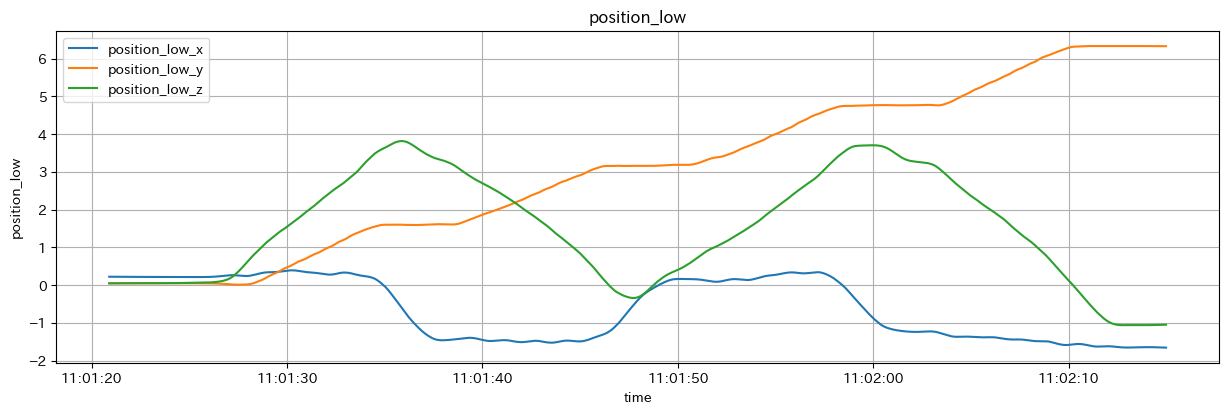

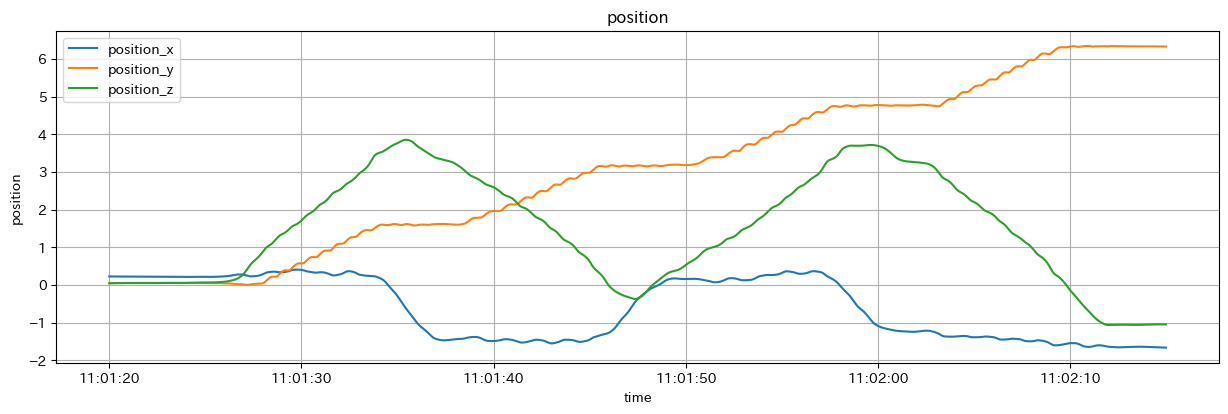

In [218]:
# 順番にプロットする
# oculus_stairs.plot('rotate', '','')
oculus_stairs.plot('position', 'low','')
oculus_stairs.plot('position', '','')
# oculus_stairs.plot('velocity', '','')
# oculus_stairs.plot('angularVelocity', '','')
# oculus_stairs.plot('acceleration', '','')

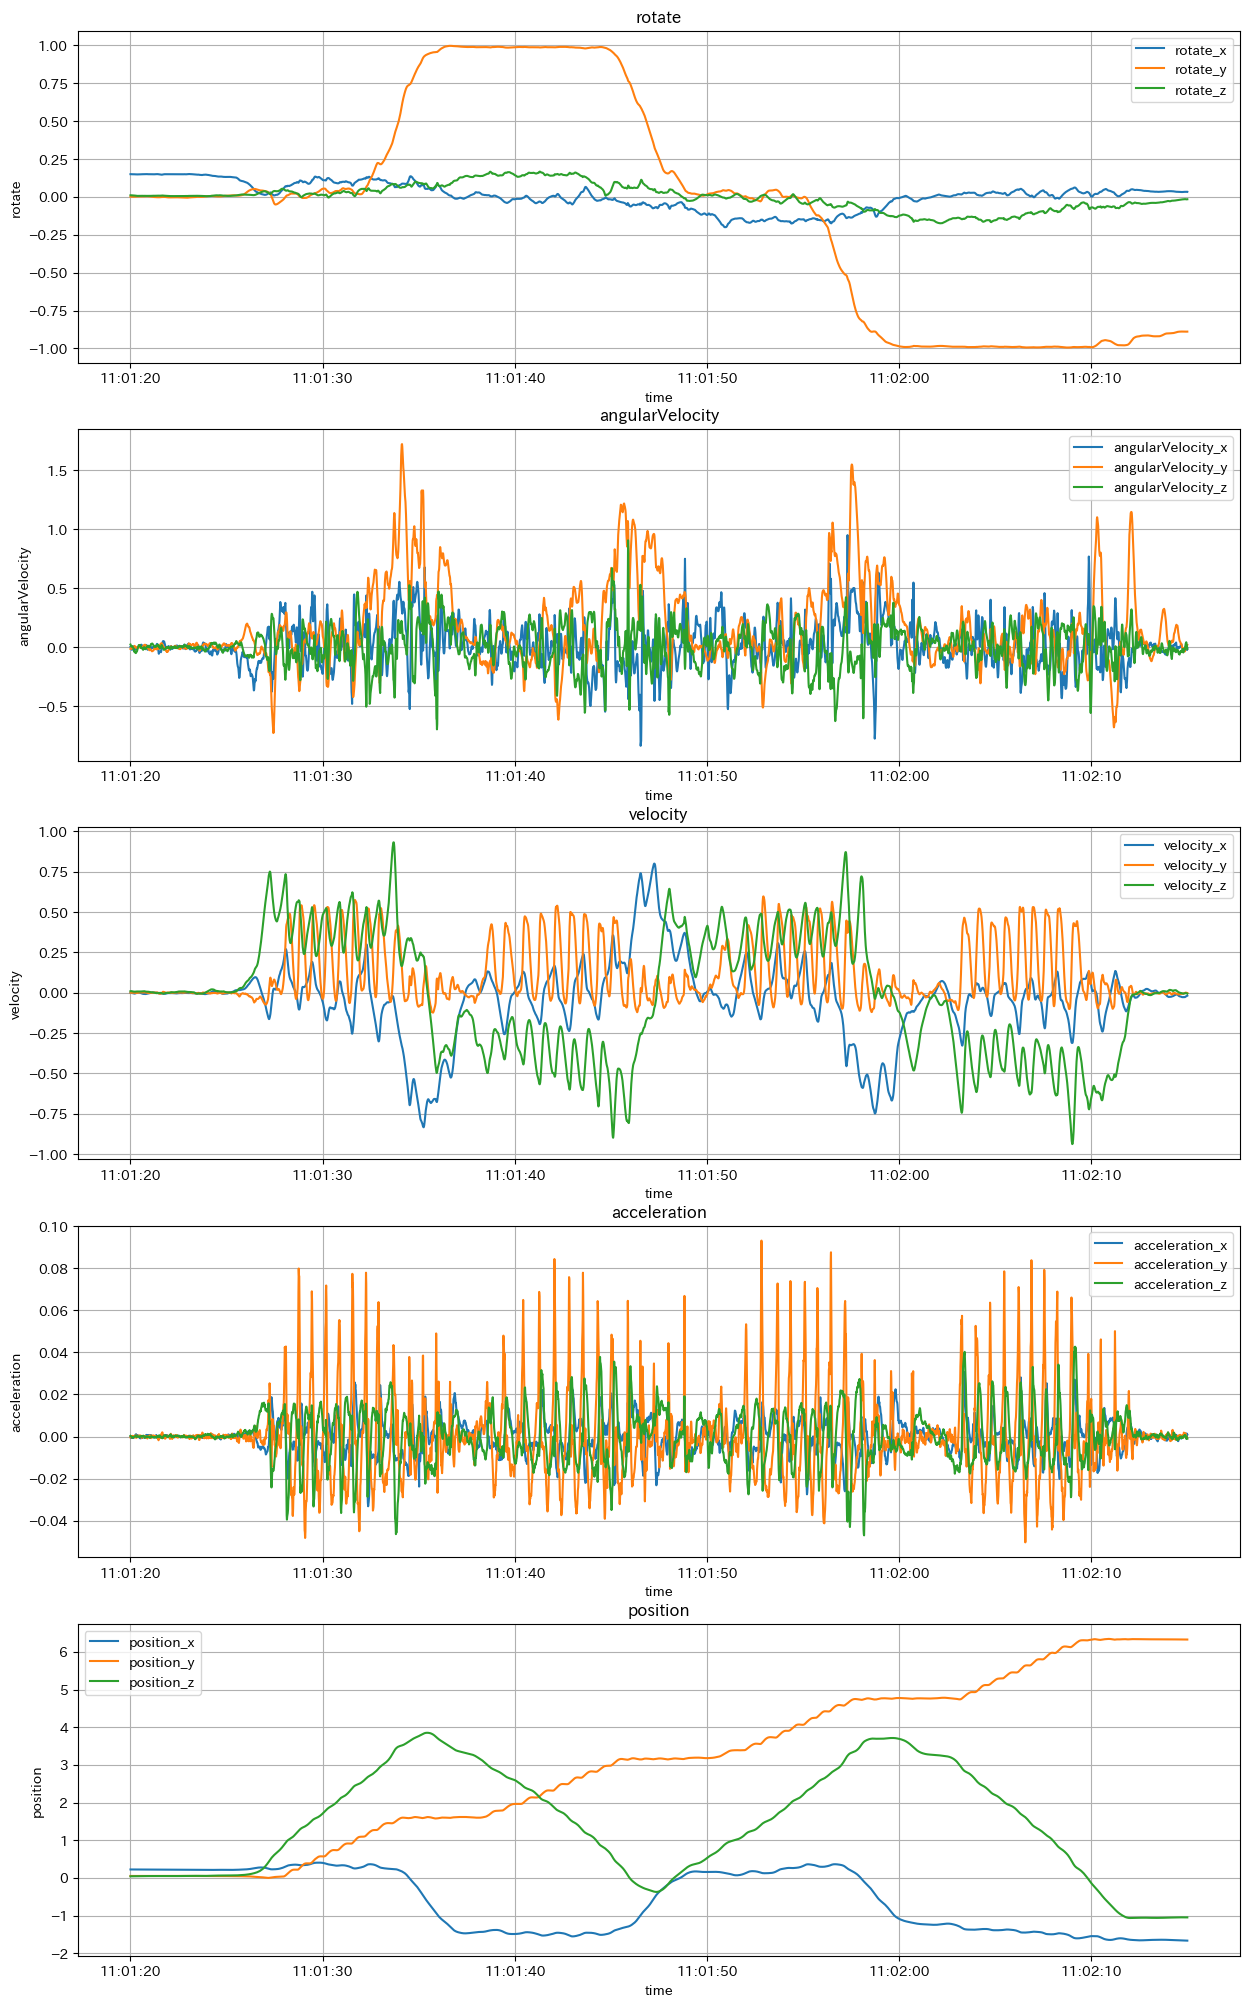

In [219]:
oculus_stairs.plot('all', '','')

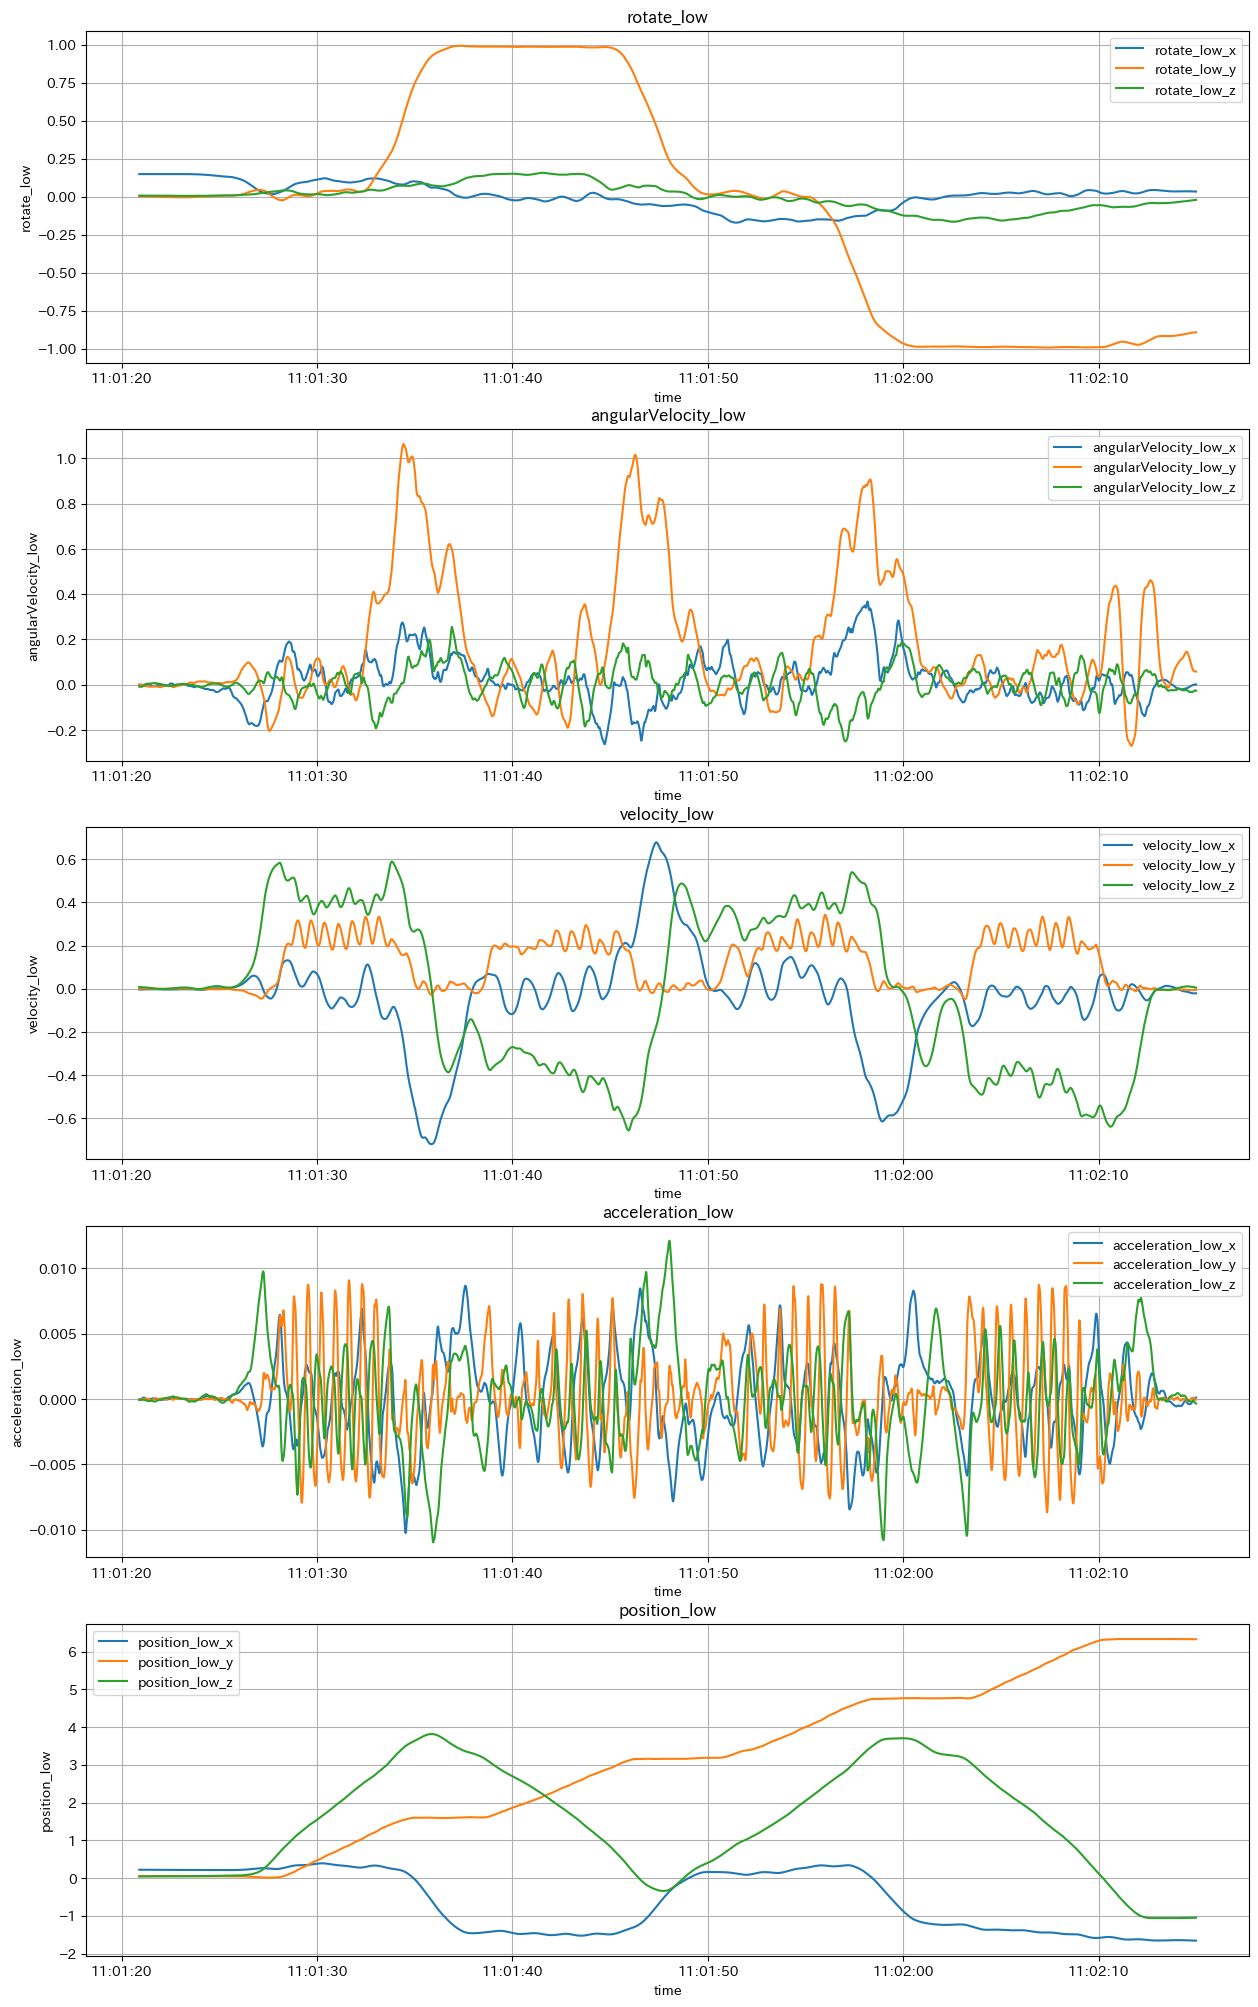

In [220]:
oculus_stairs.plot('all', 'low','')